# Librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
import nltk
import sklearn

from transformers import RobertaTokenizer

from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Importazione dataset

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv("test.csv")

## Analisi preliminari 

In [3]:
train_set.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
target_category = train_set['Class Index'].unique()
print(target_category)

[3 4 2 1]


In [5]:
category = train_set[["Class Index"]].drop_duplicates().sort_values('Class Index')
category

,Class Index
492,1
448,2
0,3
78,4


In [6]:
train_set.groupby('Class Index').Description.count()

Class Index
1    30000
2    30000
3    30000
4    30000
Name: Description, dtype: int64

<AxesSubplot:xlabel='Class Index'>

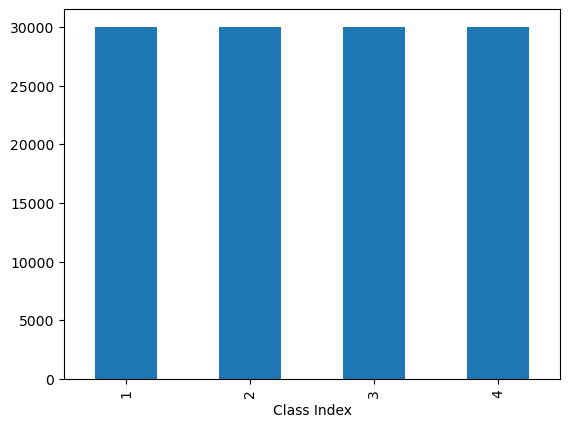

In [7]:
train_set.groupby('Class Index').Description.count().plot.bar(ylim=0)

# BPE

## BPE su train_set 

In [8]:
# Carica il tokenizzatore preaddestrato di RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Applica il tokenizzatore a ogni elemento della colonna 'Sentence'
train_set['Text_BPE'] = train_set['Description'].apply(lambda x: tokenizer.tokenize(x))

# Visualizza le prime righe per vedere il risultato
train_set['Text_BPE'].head()

0    [Reuters, Ġ-, ĠShort, -, sell, ers, ,, ĠWall, ...
1    [Reuters, Ġ-, ĠPrivate, Ġinvestment, Ġfirm, ĠC...
2    [Reuters, Ġ-, ĠSo, aring, Ġcrude, Ġprices, Ġpl...
3    [Reuters, Ġ-, ĠAuthorities, Ġhave, Ġhalted, Ġo...
4    [AFP, Ġ-, ĠT, ear, away, Ġworld, Ġoil, Ġprices...
Name: Text_BPE, dtype: object

In [9]:
# Supponiamo che il DataFrame sia chiamato 'data_ml' e la colonna con i token sia 'clear_text'

# Converte la lista di token in una stringa unica per ogni riga
train_set['Text_BPE'] = train_set['Text_BPE'].apply(lambda x: ' '.join(x))

# Visualizza le prime righe per vedere il risultato
train_set['Text_BPE'].head()


0    Reuters Ġ- ĠShort - sell ers , ĠWall ĠStreet '...
1    Reuters Ġ- ĠPrivate Ġinvestment Ġfirm ĠCarly l...
2    Reuters Ġ- ĠSo aring Ġcrude Ġprices Ġplus Ġwor...
3    Reuters Ġ- ĠAuthorities Ġhave Ġhalted Ġoil Ġex...
4    AFP Ġ- ĠT ear away Ġworld Ġoil Ġprices , Ġtopp...
Name: Text_BPE, dtype: object

## BPE su test_set 

In [10]:
# Carica il tokenizzatore preaddestrato di RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Applica il tokenizzatore a ogni elemento della colonna 'Sentence'
test_set['Text_BPE'] = test_set['Description'].apply(lambda x: tokenizer.tokenize(x))

# Visualizza le prime righe per vedere il risultato
test_set['Text_BPE'].head()

0    [Un, ions, Ġrepresenting, Ġworkers, Ġat, ĠTurn...
1    [SP, ACE, ., com, Ġ-, ĠTOR, ON, TO, ,, ĠCanada...
2    [AP, Ġ-, ĠA, Ġcompany, Ġfounded, Ġby, Ġa, Ġche...
3    [AP, Ġ-, ĠIt, 's, Ġbarely, Ġdawn, Ġwhen, ĠMike...
4    [AP, Ġ-, ĠSouthern, ĠCalifornia, 's, Ġsm, og, ...
Name: Text_BPE, dtype: object

In [11]:
# Supponiamo che il DataFrame sia chiamato 'data_ml' e la colonna con i token sia 'clear_text'

# Converte la lista di token in una stringa unica per ogni riga
test_set['Text_BPE'] = test_set['Text_BPE'].apply(lambda x: ' '.join(x))

# Visualizza le prime righe per vedere il risultato
test_set['Text_BPE'].head()


0    Un ions Ġrepresenting Ġworkers Ġat ĠTurner Ġ Ġ...
1    SP ACE . com Ġ- ĠTOR ON TO , ĠCanada Ġ-- ĠA Ġs...
2    AP Ġ- ĠA Ġcompany Ġfounded Ġby Ġa Ġchemistry Ġ...
3    AP Ġ- ĠIt 's Ġbarely Ġdawn Ġwhen ĠMike ĠFitzpa...
4    AP Ġ- ĠSouthern ĠCalifornia 's Ġsm og - fighti...
Name: Text_BPE, dtype: object

# Naive Bayes

## White space 

## BPE 

### Test_set 

In [12]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_set['Text_BPE'],train_set['Class Index'])

test_predict = nb.predict(test_set['Text_BPE'])

train_accuracy = round(nb.score(train_set['Text_BPE'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
# Supponiamo che target_category sia attualmente un array numerico o una lista di numeri
# Convertilo in una lista di stringhe
target_category = [str(name) for name in target_category]

# Ora usa questa lista modificata nel classification_report
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))


Naive Bayes Train Accuracy Score : 90% 
Naive Bayes Test Accuracy Score  : 89% 

              precision    recall  f1-score   support

           3       0.88      0.91      0.90      1855
           4       0.97      0.93      0.95      1974
           2       0.83      0.86      0.85      1831
           1       0.87      0.85      0.86      1940

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



## Decision tree

In [ ]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(train_set['Text_BPE'],train_set['Class Index'])

test_predict = dt.predict(test_set['Text_BPE'])

train_accuracy = round(dt.score(train_set['Text_BPE'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Text_BPE'], target_names=target_category))

## Random forest

In [ ]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

rfc.fit(train_set['Text_BPE'],train_set['Class Index'])

test_predict = rfc.predict(test_set['Text_BPE'])

train_accuracy = round(rfc.score(train_set['Text_BPE'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Text_BPE'])*100)

print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy ))
print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Text_BPE'], target_names=target_category))

# WHITE SPACES

In [61]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

# Definisci un trasformatore personalizzato
class ListToStringTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        # Converte una lista di token in una stringa
        return [' '.join(x) for x in X]

    def fit(self, X, y=None, **fit_params):
        return self

# Crea una pipeline che utilizza il trasformatore
pipeline = Pipeline([
    ('list_to_string', ListToStringTransformer())
])

# Supponiamo che la colonna 'TextW' contenga liste di token
dataset['Textw'] = pipeline.fit_transform(dataset['TextW'])

# Visualizza le prime righe per vedere il risultato
dataset['Textw'].head()


0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: Textw, dtype: object

In [62]:
text = dataset['Textw']
category = dataset['Class Index']

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(text,category, test_size = 0.3, random_state = 60,shuffle=True, stratify=category)

print(len(X_train))
print(len(X_test))

84000
36000


In [64]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,Y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
# Supponiamo che target_category sia attualmente un array numerico o una lista di numeri
# Convertilo in una lista di stringhe
target_category = [str(name) for name in target_category]

# Ora usa questa lista modificata nel classification_report
print(classification_report(test_predict, Y_test, target_names=target_category))


Naive Bayes Train Accuracy Score : 91% 
Naive Bayes Test Accuracy Score  : 90% 

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      8881
           1       0.98      0.95      0.96      9284
           2       0.85      0.86      0.86      8912
           3       0.86      0.87      0.87      8923

    accuracy                           0.90     36000
   macro avg       0.90      0.90      0.90     36000
weighted avg       0.90      0.90      0.90     36000



# DECISION TREE

In [60]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, Y_train)

test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 74% 

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8940
           1       0.83      0.81      0.82      9168
           2       0.69      0.70      0.70      8888
           3       0.71      0.71      0.71      9004

    accuracy                           0.74     36000
   macro avg       0.74      0.74      0.74     36000
weighted avg       0.74      0.74      0.74     36000



In [66]:
text = dataset['Text']
category = dataset['Class Index']

In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(text,category, test_size = 0.3, random_state = 60,shuffle=True, stratify=category)

print(len(X_train))
print(len(X_test))

84000
36000


# RANDOM FOREST

In [68]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

rfc.fit(X_train, Y_train)

test_predict = rfc.predict(X_test)

train_accuracy = round(rfc.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy ))
print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

K-Nearest Neighbour Train Accuracy Score : 100% 
K-Nearest Neighbour Test Accuracy Score  : 86% 

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      8661
           1       0.96      0.89      0.92      9682
           2       0.81      0.86      0.83      8462
           3       0.84      0.82      0.83      9195

    accuracy                           0.86     36000
   macro avg       0.86      0.86      0.86     36000
weighted avg       0.87      0.86      0.86     36000



# Morfessor 